<h3>Report</h3>

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import pickle

<h3>Loading Models</h3>

In [3]:
from core.network import *
from core.trainer import *

In [4]:
device = torch.device("cuda:0")
dir_load = '../models/'

In [5]:
net = LSTM(1, 98, 9, num_layers=3, device=device).to(device)
model = LSTMTrainer(net, device=device)
model2 = LSTMTrainer(net, device=device)

<h3>Dataloading for Eval</h3>

In [6]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [7]:
from core.getdata import *
from core.dataset import * 
from core.dataset2 import *

In [8]:
data = Dataset(ligands, polarization, replicas, size)
data2 = DatasetNaive(ligands, replicas, size)

In [9]:
from torch.utils.data import Dataset
from torchvision import datasets

In [10]:
print(len(data), 0.25 * len(data)) # we'll test our data on 25% of the dataset
print(len(data2), 0.25 * len(data2))

69552 17388.0
11592 2898.0


In [11]:
_, datatest = torch.utils.data.random_split(data, [69552 - 17388 - 24, 17388 + 24])
_, dataset2 = torch.utils.data.random_split(data2, [11592 - 2880, 2880]) # 302
testloader = torch.utils.data.DataLoader(datatest, batch_size=32, shuffle=True)
testloader2 = torch.utils.data.DataLoader(dataset2, batch_size=16, shuffle=True)

<h3>Evaluation Loop</h3>

In [12]:
model.load(dir_load + 'lstm1.pth') # polarized

In [13]:
polarization_true, polarization_pred, polarized_prob = np.empty([32,]).T, np.empty([32,]).T, np.empty([32,]).T

In [14]:
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    polarization_true = np.hstack([polarization_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # polarized_prob = np.hstack([polarized_prob, y_prob.T])
    y_pred = np.argmax(y_pred, axis=1)
    #import pdb; pdb.set_trace()
    polarization_pred = np.hstack([polarization_pred, y_pred.T])
    #y_true = (32, ); y_pred = (32, )

In [15]:
model2.load(dir_load + 'lstm.pth') # naive

In [16]:
naive_true, naive_pred, naive_prob = np.empty([16,]).T, np.empty([16,]).T, np.empty([16,]).T

In [17]:
for x2, y2 in testloader2:
    x2, y2 = x2.to(device), y2.to(device)
    y_true = y2.detach().cpu().numpy()
    naive_true = np.hstack([naive_true, y_true.T])
    y_pred = model2.network(x2)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # naive_prob = np.hstack([naive_prob, y_pred.T])
    y_pred = np.argmax(y_pred, axis=1)
    #import pdb; pdb.set_trace()
    naive_pred = np.hstack([naive_pred, y_pred.T])
    #y_true = (16, ); y_pred = (16, )

In [18]:
polarization_true, polarization_pred = polarization_true[32:], polarization_pred[32:]
naive_true, naive_pred = naive_true[16:], naive_pred[16:]
print(naive_true.shape, naive_pred.shape, polarization_true.shape, polarization_pred.shape)

(2880,) (2880,) (17412,) (17412,)


In [19]:
comparison = np.vstack([polarization_true, polarization_pred]).T
comparison2 = np.vstack([naive_true, naive_pred]).T

In [20]:
df, df2 = pd.DataFrame(comparison), pd.DataFrame(comparison2)

In [21]:
print(df)

         0    1
0      0.0  0.0
1      7.0  7.0
2      2.0  2.0
3      7.0  7.0
4      5.0  5.0
...    ...  ...
17407  1.0  1.0
17408  0.0  0.0
17409  8.0  8.0
17410  5.0  5.0
17411  0.0  0.0

[17412 rows x 2 columns]


In [22]:
print(df2)

        0    1
0     4.0  4.0
1     4.0  4.0
2     7.0  7.0
3     2.0  2.0
4     2.0  2.0
...   ...  ...
2875  5.0  5.0
2876  8.0  8.0
2877  2.0  2.0
2878  3.0  3.0
2879  8.0  8.0

[2880 rows x 2 columns]


<h3>Metrics</h3>

In [23]:
# ACCURACY
print(f' Naive Accuracy: {sum(df2[0] == df2[1])/2880} \n Polarized Accuracy: {sum(df[0] == df[1])/17412}')

 Naive Accuracy: 0.95625 
 Polarized Accuracy: 0.912359292441994


In [24]:
naive_report = sklearn.metrics.classification_report(df2[0], df2[1], target_names=ligands, output_dict=True)
naive_rep = pd.DataFrame(naive_report).transpose()

polarized_report = sklearn.metrics.classification_report(df[0], df[1], target_names=ligands, output_dict=True)
polarized_rep = pd.DataFrame(polarized_report).transpose()

In [25]:
print(naive_rep)

              precision    recall  f1-score     support
TNF            0.959627  0.965625  0.962617   320.00000
R84            0.984962  0.839744  0.906574   312.00000
PIC            0.990536  0.987421  0.988976   318.00000
P3K            0.957704  0.984472  0.970904   322.00000
FLA            0.939759  0.975000  0.957055   320.00000
CpG            0.948387  0.930380  0.939297   316.00000
FSL            0.903537  0.946128  0.924342   297.00000
LPS            0.948718  0.976540  0.962428   341.00000
UST            0.976471  0.994012  0.985163   334.00000
accuracy       0.956250  0.956250  0.956250     0.95625
macro avg      0.956634  0.955480  0.955262  2880.00000
weighted avg   0.957006  0.956250  0.955851  2880.00000


In [26]:
print(polarized_rep)

              precision    recall  f1-score       support
TNF            0.934569  0.880329  0.906638   1947.000000
R84            0.932584  0.912088  0.922222   1911.000000
PIC            0.927932  0.954499  0.941028   1956.000000
P3K            0.896065  0.908905  0.902439   1954.000000
FLA            0.858486  0.893869  0.875820   1941.000000
CpG            0.885406  0.892284  0.888832   1931.000000
FSL            0.885111  0.894792  0.889925   1920.000000
LPS            0.901221  0.875193  0.888017   1939.000000
UST            0.994283  1.000000  0.997133   1913.000000
accuracy       0.912359  0.912359  0.912359      0.912359
macro avg      0.912851  0.912440  0.912451  17412.000000
weighted avg   0.912744  0.912359  0.912356  17412.000000


In [27]:
naive_confusion = sklearn.metrics.confusion_matrix(df2[0], df2[1])
nccm = sklearn.metrics.ConfusionMatrixDisplay(naive_confusion)

polarized_confusion = sklearn.metrics.confusion_matrix(df[0], df[1])
pccm = sklearn.metrics.ConfusionMatrixDisplay(polarized_confusion)

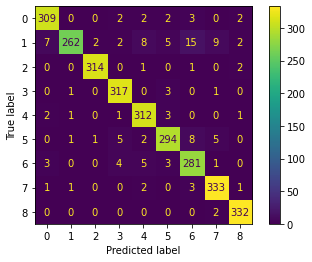

In [28]:
nccm.plot()

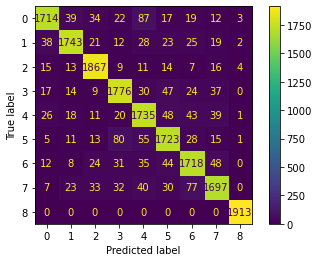

In [29]:
pccm.plot()